# Computing the core Čech filtration for a fixed $k$

In this notebook, we show how to compute the persistent homology of the core Čech filtration in the simplest case where $k$ is fixed. For $k=1$ we demonstrate that the core Čech filtration is indeed equivalent to the usual Čech filtration by comparing it to the $\alpha$-complex. Furthermore, we compute the persistent homology of a noisy circle for different values of $k$ using the core Čech filtration.

In [1]:
import math
import gudhi
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from miniball import Miniball
from scipy.spatial import KDTree

from datasets import sample_circle, sample_rectangle
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [2]:
rng = np.random.default_rng(seed=0)

### Compute distances to k-nearest neighbors in X

In [3]:
def k_nearest_neighbor_distances(X, k):
    kd_tree = KDTree(X)
    k_core_distances, _ = kd_tree.query(X, k=k, workers=-1)
    return k_core_distances  

### Compute filtration values of faces from squared radius and core values

In [4]:
def core_value(face, squared_radius, core_values):
    max_core = max(core_values[face]) 
    return max(squared_radius ** 0.5, max_core)

### Compute core value for each points

In [13]:
def vertex_values(X, max_k, max_r):
    if max_r is None or max_k <= 1:
        return k_nearest_neighbor_distances(X, k=[max_k])
    k_core_distances = k_nearest_neighbor_distances(X, np.arange(max_k))
    line = np.linspace(max_r, 0, num=max_k)
    if max_k>1:
        indices = np.argmax(line <= k_core_distances, axis=1)
        values = k_core_distances[np.arange(len(k_core_distances)), indices]
    else:
        values = np.array(k_core_distances)
    return values

### Compute core simplex tree from a simplex tree filtered by squared radius and a point cloud

In [6]:
def core_complex(X, st, max_k, max_r=None):
    k_core_distances = vertex_values(X, max_k, max_r)
    for face, val in st.get_filtration():
        st.assign_filtration(face, core_value(np.array(list(face)), val, k_core_distances))
    return st

### Compute simplex tree of a point cloud filtered by squared radius

In [7]:
def cech_squared_radius(X, max_dim=1):
    st = gudhi.SimplexTree()
    for dim in range(max_dim+1):
        for face in combinations(range(len(X)),dim+1):
            val = Miniball(X[list(face)]).squared_radius()
            st.insert(face, val)
    return st

### Construct core cech simplex tree

In [8]:
def core_cech(X, max_k=10, max_r=None, max_dim=1):
    st = cech_squared_radius(X, max_dim=max_dim)
    return core_complex(X, st, max_k, max_r)

### Construct core alpha simplex tree

In [9]:
def core_alpha(X, max_k=10, max_r=None, precision='safe'):
    st = gudhi.AlphaComplex(points=X, precision=precision).create_simplex_tree()
    return core_complex(X, st, max_k, max_r)

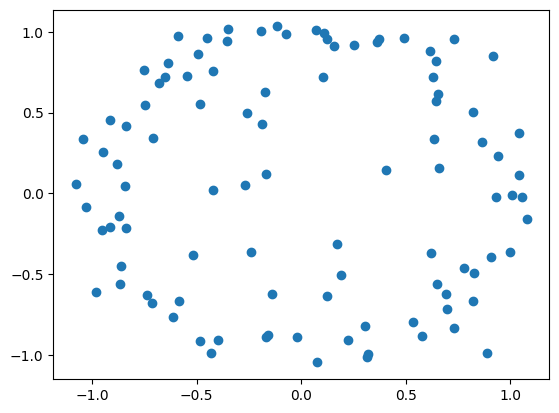

In [10]:
N = 60
M = 40
Z = sample_circle(N, rng, variance=0.005)
Y = sample_rectangle(M, rng)
X = np.r_[Z, Y]
plt.scatter(*X.T)
plt.show()

In [14]:
st_core = core_cech(X=X, max_dim=2, max_k=1)
st_alpha = core_alpha(X=X, max_k=1)

In [15]:
max_r = 2*math.sqrt(Miniball(X).squared_radius())

In [16]:
st_core = core_cech(X=X, max_dim=2, max_k=1, max_r=max_r)
st_alpha = core_alpha(X=X, max_k=20, max_r=max_r)

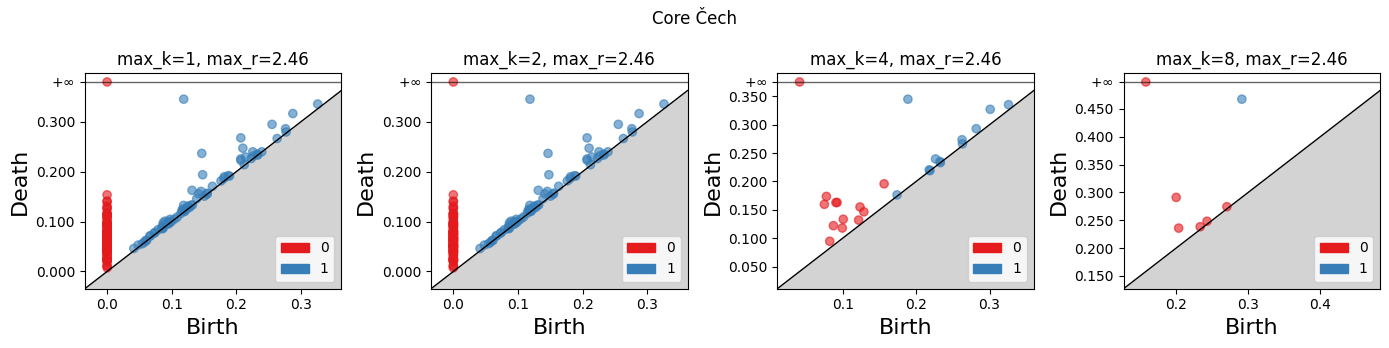

In [17]:
max_ks = [1, 2, 4, 8]
max_r = 2*math.sqrt(Miniball(X).squared_radius())

fig, axs = plt.subplots(ncols=len(max_ks), figsize=(14, 14 / len(max_ks)))
fig.suptitle("Core Čech")
for i, max_k in enumerate(max_ks):
    st_core = core_cech(X, max_dim=2, max_k=max_k, max_r=max_r)
    gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[i])
    axs[i].set_title(f"max_k={max_k}, max_r={max_r:.2f}")
fig.tight_layout()
plt.show()

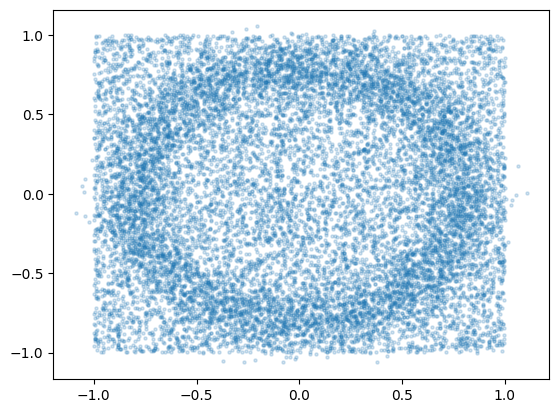

In [18]:
N = 5_000
M = 10_000
Z = sample_circle(N, rng, r=0.8, variance=0.01)
Y = sample_rectangle(M, rng)
X = np.r_[Z, Y]
plt.scatter(*X.T, s=5, alpha=0.2)
plt.show()

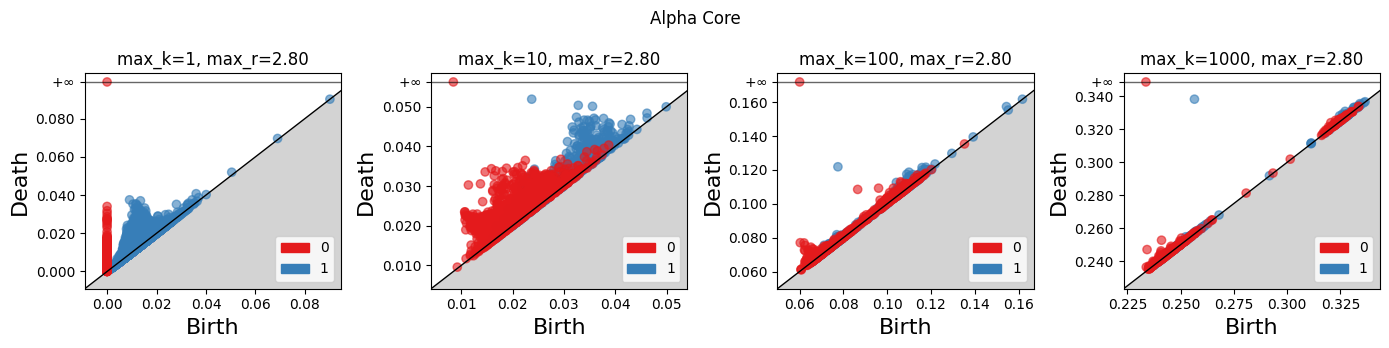

In [19]:
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())

fig, axs = plt.subplots(ncols=len(max_ks), figsize=(14, 14 / len(max_ks)))
fig.suptitle("Alpha Core")
for i, max_k in enumerate(max_ks):
    st_alpha_core = core_alpha(X, max_k=max_k, max_r=max_r)
    gudhi.plot_persistence_diagram(st_alpha_core.persistence(), axes=axs[i])
    axs[i].set_title(f"max_k={max_k}, max_r={max_r:.2f}")
fig.tight_layout()
plt.show()